# Setup

There is a hidden initialization cell below. It should run automatically and print, but if it does not, please run it.

In [12]:
%matplotlib inline

print('Loading libraries... Please wait.')

from IPython.display import display, clear_output
import ipywidgets as widgets
import random
import sys
from sklearn.metrics import confusion_matrix, accuracy_score

from esper.prelude import *
from esper.widget import *
import esper.face_embeddings as face_embeddings


WIDGET_STYLE_ARGS = {'description_width': 'initial'}


def query_faces(ids):
    faces = Face.objects.filter(id__in=ids)
    return faces.values(
        'id', 'bbox_y1', 'bbox_y2', 'bbox_x1', 'bbox_x2',
        'frame__number', 'frame__video__id', 'frame__video__fps',
        'shot__min_frame', 'shot__max_frame')


def query_sample(qs, n):
    return qs.order_by('?')[:n]


def query_faces_result(faces, expand_bbox=0.05):
    """Replaces qs_to_result"""
    result = []
    for face in faces:
        if (face.get('shot__min_frame') is not None and 
                face.get('shot__max_frame') is not None):
            min_frame = int(
                (face['shot__min_frame'] + 
                 face['shot__max_frame']) / 2)
        else:
            min_frame = face['frame__number']
        face_result = {
            'type': 'flat', 'label': '', 
            'elements': [{
                'objects': [{
                    'id': face['id'],
                    'background': False,
                    'type': 'bbox',
                    'bbox_y1': max(face['bbox_y1'] - expand_bbox, 0),
                    'bbox_y2': min(face['bbox_y2'] + expand_bbox, 1),
                    'bbox_x1': max(face['bbox_x1'] - expand_bbox, 0),
                    'bbox_x2': min(face['bbox_x2'] + expand_bbox, 1),
                }], 
                'min_frame': min_frame,
                'video': face['frame__video__id']
            }]
        }
        result.append(face_result)
    return {'type': 'Face', 'count': 0, 'result': result}


def simple_random_sampler(n):
    return set(face_embeddings.sample(n))


GENDER_LONG_NAME = {'F': 'female', 'M': 'male'}
def save_gender_labels(ids, gender_name):
    gender = Gender.objects.get(name=gender_name)
    labeler = Labeler.objects.get(name=HANDLABELER_NAME)
    for face_id in ids:
        fg, created = FaceGender.objects.get_or_create(
            face_id=face_id, labeler=labeler, 
            defaults={'gender': gender}, probability=1.)
        if not created:
            print('{} was already labeled: updated it'.format(face_id))
            fg.gender = gender
        fg.save()
    print('Saved {} {} labels'.format(len(ids), GENDER_LONG_NAME[gender_name]))
    

def label_random_faces(n, sampler=simple_random_sampler, order_by='random'):
    print('Loading {} faces'.format(n))
    # Simple random sample across the entire dataset
    face_ids = sampler(n)
    faces = list(query_faces(face_ids))
    if order_by == 'gender':
        genders = {
            fg['face__id'] : fg['gender__id']
            for fg in FaceGender.objects.filter(face__id__in=face_ids).values('face__id', 'gender__id')
        }
        faces.sort(key=lambda x: genders.get(x['id'], 0))
    elif order_by == 'random':
        random.shuffle(faces)
    else:
        print('Unknown sort order: using random instead', file=sys.stderr)
    selection_widget = esper_widget(
        query_faces_result(faces), 
        disable_playback=True, jupyter_keybindings=True,
        crop_bboxes=True, results_per_page=faces_per_page())
    
    submit_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Save to database',
        disabled=False,
        button_style='danger'
    )
    def on_submit(b):
        male_ids = [faces[i]['id'] for i in selection_widget.selected]
        female_ids = [faces[i]['id'] for i in selection_widget.ignored]
        clear_output()
        save_gender_labels(male_ids, 'M')
        save_gender_labels(female_ids, 'F')
        label_random_faces(n, sampler, order_by)
    submit_button.on_click(on_submit)
    
    refresh_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Refresh (w/o saving)',
        disabled=False,
        button_style=''
    )
    def on_refresh(b):
        clear_output()
        label_random_faces(n, sampler, order_by)
    refresh_button.on_click(on_refresh)
    
    dismiss_button = widgets.Button(
        layout=widgets.Layout(width='auto'),
        style=WIDGET_STYLE_ARGS,
        description='Dismiss widget (w/o saving)',
        disabled=False,
        button_style=''
    )
    def on_dismiss(b):
        clear_output()
        print('Dismissed widget. Re-run cell to get it back.')
    dismiss_button.on_click(on_dismiss)
    
    display(widgets.HBox([submit_button, refresh_button, dismiss_button]))
    display(selection_widget)
    

MODEL_LABELER_NAME = 'knn-gender'
def print_gender_validation_stats(normalize=None, norm_axis=1):
    labeler = Labeler.objects.get(name=HANDLABELER_NAME)
    hand_face_genders = {
        fg['face__id']: fg['gender__id']
        for fg in FaceGender.objects.filter(
            labeler=labeler
        ).values('face__id', 'gender__id')
    }
    gender_id_dict = {g.name: g.id for g in Gender.objects.all()}
    male_count = sum((
        1 for g in hand_face_genders.values() if g == gender_id_dict['M']
    ))
    female_count = sum((
        1 for g in hand_face_genders.values() if g == gender_id_dict['F']
    ))
    print('{} faces have been hand-labeled ({} male, {} female)'.format(
          len(hand_face_genders), male_count, female_count))
    
    y_pred = []
    y_truth = []
    for fg in FaceGender.objects.filter(
        face__id__in=list(hand_face_genders.keys()), 
        labeler__name=MODEL_LABELER_NAME
    ).values('face__id', 'gender__id'):
        y_pred.append(fg['gender__id'])
        y_truth.append(hand_face_genders[fg['face__id']])
    
    cm = confusion_matrix(y_truth, y_pred)
    
    if normalize:
        if norm_axis == 1:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        else:
            cm = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
    classes = ['Male', 'Female']
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.title('Gender confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Hand label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
    print('Overall accuracy: {:0.2f}'.format(
          accuracy_score(y_truth, y_pred)))
        
    
DEFAULT_FACES_PER_PAGE = 50
_faces_per_page_slider = widgets.IntSlider(
    value=DEFAULT_FACES_PER_PAGE,
    style=WIDGET_STYLE_ARGS,
    min=25,
    max=100,
    step=1,
    description='Faces per widget page:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)
def faces_per_page():
    try:
        return _faces_per_page_slider.value
    except:
        return DEFAULT_FACES_PER_PAGE

print('Done!')

display(_faces_per_page_slider)

HANDLABELER_NAME = 'handlabeled-gender-validation'
print('New labels will be saved with labeler:', HANDLABELER_NAME)

Loading libraries... Please wait.
Done!


IntSlider(value=50, continuous_update=False, description='Faces per widget page:', min=25, style=SliderStyle(d…

New labels will be saved with labeler: handlabeled-gender-validation


# Labeling

`label_random_faces()` will sample faces from the dataset.

<b>Keys:</b>
 - To label a <b>male</b> face, press '['. To label all faces on a page, press '{' (i.e., shift + '[').
 - To label a <b>female</b> face, press ']'. To label all faces on a page, press '}' (i.e., shift + ']').
 - To expand an image, press '=', and press again to shrink it.
 - To label ALL previously unlabeled faces up to and including the current face as <b>male</b>, press '?' (i.e., shift + '/').
 - Do not highlight if unsure.
 
Once you are satisfied with your selections, press <b>save to database</b>. Re-run this cell as needed.

Note: the bounding boxes have been expanded by 5%.

In [2]:
label_random_faces(
    faces_per_page(),  # number of faces to show (exactly 1 page)
    sampler=simple_random_sampler,
    order_by='gender'  # predicted men then women
#     order_by='random'
)

Dismissed widget. Re-run cell to get it back.


You can view the current validation statistics by calling `print_gender_validation_stats()`.

12669 faces have been hand-labeled (8641 male, 4028 female)


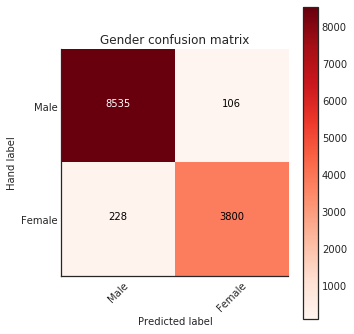

Overall accuracy: 0.97


In [11]:
print_gender_validation_stats(normalize=False)